In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## Section 7.1: Estimation {-}

### Section 7.1.1: Unbiasedness and Consistency {-}

In [2]:
# simulation parameters
n = 100 # sample size
mu0 = 0 # mean of Y_i(0)
sd0 = 1 # standard deviation of Y_i(0)
mu1 = 1 # mean of Y_i(1)
sd1 = 1 # standard deviation of Y_i(1)

# generate a sample 
Y0 = stats.norm.rvs(size=n, loc=mu0, scale=sd0)
Y1 = stats.norm.rvs(size=n, loc=mu1, scale=sd1)
tau = Y1 - Y0 # individual treatment effect
# true value of the sample average treatment effect
SATE = tau.mean()
SATE

1.1697124670570664

In [3]:
# repeatedly conduct randomized controlled trials
sims = 5000 # repeat 5,000 times, we could do more
diff_means = np.zeros(sims) # container 
sample_vector = np.concatenate((np.ones(int(n/2)), np.zeros(int(n/2))))

for i in range(sims):
    # randomize the treatment by sampling of a vector of 0's and 1's
    treat = np.random.choice(sample_vector, size=n, replace=False)
    # difference-in-means
    diff_means[i] = Y1[treat==1].mean() - Y0[treat==0].mean()

# estimation of error for SATE
est_error = diff_means - SATE

est_error.mean()

0.001367231467261098

In [4]:
pd.Series(est_error).describe().round(5)

count    5000.00000
mean        0.00137
std         0.13285
min        -0.47264
25%        -0.09028
50%         0.00054
75%         0.09551
max         0.44256
dtype: float64

In [5]:
# PATE simulation
PATE = mu1 - mu0
diff_means = np.zeros(sims)

for i in range(sims):
    # generate a sample for each simulation 
    Y0 = stats.norm.rvs(size=n, loc=mu0, scale=sd0)
    Y1 = stats.norm.rvs(size=n, loc=mu1, scale=sd1)
    treat = np.random.choice(sample_vector, size=n, replace=False)
    diff_means[i] = Y1[treat==1].mean() - Y0[treat==0].mean()

# estimation error for PATE
est_error = diff_means - PATE

# unbiased
est_error.mean()

0.001799964703385013

In [6]:
pd.Series(est_error).describe().round(5)

count    5000.00000
mean        0.00180
std         0.19858
min        -0.68073
25%        -0.13276
50%         0.00138
75%         0.13692
max         0.89020
dtype: float64

### Section 7.1.2: Standard Error {-}

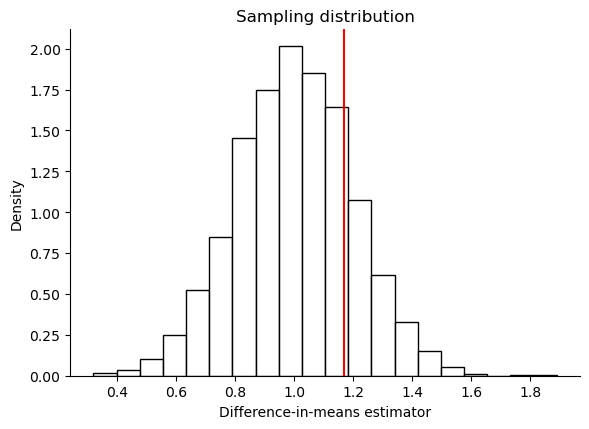

In [7]:
sns.displot(
    diff_means, stat='density', color='white', edgecolor='black',
    height=4, aspect=1.5, bins=20
).set(title='Sampling distribution', xlabel='Difference-in-means estimator')

plt.axvline(SATE, color='red') # true value of SATE

In [8]:
diff_means.std(ddof=1)

0.1985836723621929

In [9]:
np.sqrt(((diff_means - SATE)**2).mean())

0.26004268165157823

In [10]:
# PATE simulation with standard error
sims = 5000
diff_means = np.zeros(sims)
se = np.zeros(sims)

for i in range(sims):
    # generate a sample for each simulation 
    Y0 = stats.norm.rvs(size=n, loc=mu0, scale=sd0)
    Y1 = stats.norm.rvs(size=n, loc=mu1, scale=sd1)
    # randomize treatment by sampling the vector of 0's and 1's created above 
    treat = np.random.choice(sample_vector, size=n, replace=False)
    diff_means[i] = Y1[treat==1].mean() - Y0[treat==0].mean()
    se[i] = (np.sqrt(Y1[treat==1].var(ddof=1) / (n/2) + 
                     Y0[treat==0].var(ddof=1) / (n/2)))
    
diff_means.std(ddof=1)

0.2006386254978984

In [11]:
se.mean()

0.1995025026886699

### Section 7.1.3: Confidence Intervals {-}

In [12]:
n = 1000 # sample size
x_bar = 0.6 # point estimate
s_e = np.sqrt(x_bar * (1-x_bar) / n) # standard error

# 99% confidence intervals; display as a tuple
((x_bar - stats.norm.ppf(0.995) * s_e).round(5), 
 (x_bar + stats.norm.ppf(0.995) * s_e).round(5))

(0.5601, 0.6399)

In [13]:
# 95% confidence intervals
((x_bar - stats.norm.ppf(0.975) * s_e).round(5), 
 (x_bar + stats.norm.ppf(0.975) * s_e).round(5))

(0.56964, 0.63036)

In [14]:
# 90% confidence intervals
((x_bar - stats.norm.ppf(0.95) * s_e).round(5), 
 (x_bar + stats.norm.ppf(0.95) * s_e).round(5))

(0.57452, 0.62548)

In [15]:
# empty container matrices for 2 sets of confidence intervals
ci95 = np.zeros(sims*2).reshape(sims, 2)
ci90 = np.zeros(sims*2).reshape(sims, 2)

# 95 percent confidence intervals
ci95[:,0] = diff_means - stats.norm.ppf(0.975) * se # lower limit
ci95[:,1] = diff_means + stats.norm.ppf(0.975) * se # upper limit

# 90 percent confidence intervals
ci90[:,0] = diff_means - stats.norm.ppf(0.95) * se # lower limit
ci90[:,1] = diff_means + stats.norm.ppf(0.95) * se # upper limit

# coverage rate for 95% confidence interval
((ci95[:,0] <= 1) & (ci95[:,1] >= 1)).mean()

0.9448

In [16]:
# coverage rate for 90% confidence interval
((ci90[:,0] <= 1) & (ci90[:,1] >= 1)).mean()

0.8954

In [17]:
p = 0.6 # true parameter value
n = np.array([50, 100, 1000]) # 3 sample sizes to be examined
alpha = 0.05
sims = 5000 # number of simulations
results = np.zeros(len(n)) # a container for results

for i in range(len(n)):
    ci_results = np.zeros(sims) # a container for whether CI contains truth
    # loop for repeated hypothetical survey sampling
    for j in range(sims):
        data = stats.binom.rvs(n=1, p=p, size=n[i]) # simple random sampling
        x_bar = data.mean() # sample proportion as an estimate
        s_e = np.sqrt(x_bar * (1-x_bar) / n[i]) # standard errors
        ci_lower = x_bar - stats.norm.ppf(1-alpha/2) * s_e
        ci_upper = x_bar + stats.norm.ppf(1-alpha/2) * s_e
        ci_results[j] = (p >= ci_lower) & (p <= ci_upper)
    # proportion of CIs that contain the true value
    results[i] = ci_results.mean()

results

array([0.9394, 0.9422, 0.9492])

### Section 7.1.4: Margin of Error and Sample Size Calculation in Polls {-}

**In Progress**